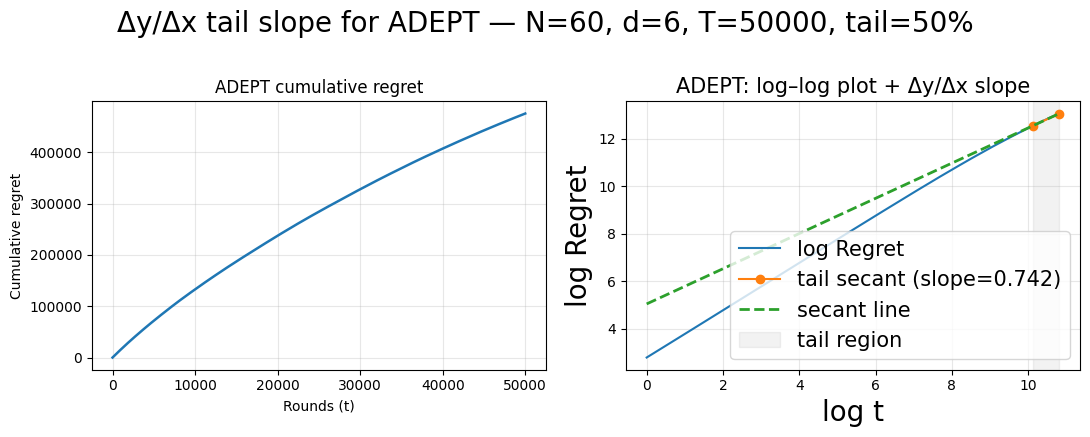

Secant slope (Δy/Δx) on the tail: 0.7423


In [ ]:
# ============================================================
# ADEPT (two-point, whitened) — log(Regret) with secant slope
# ============================================================

import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt

# -----------------------
# Config
# -----------------------
N, d = 60, 6
T = 50_000
NOISE_SD = 0.5
R_P_SCALE = 8.0
MASTER_SEED = 123
tail_frac = 0.5  # use the last 50% to estimate asymptotic slope

# -----------------------
# Helpers
# -----------------------
def proj_ball(v, R):
    n = la.norm(v)
    return v if (n <= R or n == 0) else (v * (R/n))

def best_price_in_ball(H, Hz, R, tol=1e-8, maxit=100):
    eps = 1e-8
    p_free = la.solve(2*H + eps*np.eye(H.shape[0]), Hz)
    if la.norm(p_free) <= R:
        return p_free
    lam_lo, lam_hi = 0.0, 1.0
    for _ in range(60):
        p = la.solve(2*H + lam_hi*np.eye(H.shape[0]), Hz)
        if la.norm(p) <= R: break
        lam_hi *= 2.0
    for _ in range(maxit):
        lam_mid = 0.5*(lam_lo + lam_hi)
        p = la.solve(2*H + lam_mid*np.eye(H.shape[0]), Hz)
        nrm = la.norm(p)
        if abs(nrm - R) <= tol: return proj_ball(p, R)
        if nrm > R: lam_lo = lam_mid
        else:       lam_hi = lam_mid
    return proj_ball(p, R)

# -----------------------
# Instance (non-orthonormal U, quadratic revenue)
# -----------------------
def make_instance(N, d, noise_sd, seed):
    rng = np.random.default_rng(seed)
    U_raw = rng.normal(size=(N, d))
    C = 0.6*np.ones((d, d)) + 0.4*np.eye(d)
    U = U_raw @ la.cholesky(C)
    A = rng.normal(size=(d, d))
    V = A @ A.T + 0.5*np.eye(d)
    z = rng.normal(loc=3.0, scale=1.0, size=d)
    Hz = U @ z
    H  = U @ V @ U.T
    R_p = R_P_SCALE * np.sqrt(d)

    def true_revenue(p): return p @ Hz - p @ (H @ p)
    def noisy_revenue(p): return true_revenue(p) + rng.normal(0.0, noise_sd)

    p_star_ball = best_price_in_ball(H + 1e-8*np.eye(N), Hz, R_p)
    O, P = la.qr(U, mode='reduced')
    V_tilde = P @ V @ P.T
    normVt = la.norm(V_tilde, 2)
    return O, R_p, p_star_ball, true_revenue, noisy_revenue, normVt

# -----------------------
# ADEPT (two-point, whitened φ; p = O φ)
# -----------------------
def run_adept_two_point(T, O, R_p, true_rev, noisy_rev, p_star_ball, normVt, seed):
    rng = np.random.default_rng(seed)
    d = O.shape[1]
    eta   = (0.9 / (1.0 + normVt) / (T**0.5)) / 10.0
    delta = (1.0 / ((1.0 + normVt)**0.5) / (T**0.25)) * 0.8
    phi = np.zeros(d)
    reg_hist, cum_reg = np.empty(T, float), 0.0
    for t in range(T):
        u = rng.normal(size=d); u /= la.norm(u) + 1e-12
        p_plus  = proj_ball(O @ (phi + delta*u), R_p)
        p_minus = proj_ball(O @ (phi - delta*u), R_p)
        r_plus, r_minus = noisy_rev(p_plus), noisy_rev(p_minus)
        g = -(r_plus - r_minus) * u / (2.0*delta)
        phi = phi - eta*g
        nphi = la.norm(phi)
        if nphi > R_p: phi *= (R_p/nphi)
        cum_reg += true_rev(p_star_ball) - true_rev(p_plus)
        reg_hist[t] = cum_reg
    return reg_hist

# -----------------------
# Run, compute Δy/Δx slope, plot
# -----------------------
def main():
    O, R_p, p_star_ball, true_rev, noisy_rev, normVt = make_instance(
        N=N, d=d, noise_sd=NOISE_SD, seed=MASTER_SEED
    )
    reg = run_adept_two_point(
        T=T, O=O, R_p=R_p,
        true_rev=true_rev, noisy_rev=noisy_rev,
        p_star_ball=p_star_ball, normVt=normVt,
        seed=MASTER_SEED + 42
    )

    t = np.arange(1, T+1)
    eps = 1e-12
    x = np.log(t)
    y = np.log(np.maximum(reg, eps))

    # Tail indices
    i0 = int((1.0 - tail_frac) * T)
    x0, y0 = x[i0], y[i0]
    x1, y1 = x[-1], y[-1]

    # Secant slope: Δy/Δx over the tail
    slope = (y1 - y0) / (x1 - x0)
    intercept = y0 - slope * x0  # for plotting the line

    # Plots
    fig, axs = plt.subplots(1, 2, figsize=(11, 4.5))

    axs[0].plot(t, reg, lw=1.8)
    axs[0].set_title("ADEPT cumulative regret")
    axs[0].set_xlabel("Rounds (t)")
    axs[0].set_ylabel("Cumulative regret")
    axs[0].grid(alpha=0.3)

    axs[1].plot(x, y, lw=1.5, label="log Regret")
    axs[1].plot([x0, x1], [y0, y1], 'o-', label=f"tail secant (slope={slope:.3f})")
    axs[1].plot(x, intercept + slope * x, '--', lw=2.0, label="secant line")
    axs[1].axvspan(x0, x1, color='gray', alpha=0.1, label="tail region")
    axs[1].set_title("ADEPT: log–log plot + Δy/Δx slope",fontsize=15)
    axs[1].set_xlabel("log t",fontsize=20)
    axs[1].set_ylabel("log Regret",fontsize=20)
    axs[1].legend(loc="best",fontsize=15)
    axs[1].grid(alpha=0.3)

    fig.suptitle(f"Δy/Δx tail slope for ADEPT — N={N}, d={d}, T={T}, tail={int(tail_frac*100)}%", fontsize=20)
    fig.tight_layout(rect=[0, 0.02, 1, 0.96])
    plt.show()

    print(f"Secant slope (Δy/Δx) on the tail: {slope:.4f}")

if __name__ == "__main__":
    main()
